## Testing algorithms for tweet_data class.

These algorithms use pointwise_correlation.py and poisson_processes.py to create mixed populations of more or less correlated lagging time series.  These time series are passed into the correlation measure (either using $\sigma_1$ when time series are drawn from a population with a known proportion of entries, or $\sigma_2$ based on measuring the proportion for each time series).  Correlations become edge probabilities in a fully connected networkx graph.  These are then analysed using a community detection method (community_louvain) to attempt to recreate the original populations as fully connected subgraphs. The success of this is measured using an f-score based on edges in these subgraphs that connect objects that were actually from the same population.



### Test algorithm
The cell below runs the test (requires the methods in the cells below to be stored first)

T is 1000
Now initialising externally
Initialising with fixed means
Initialising a random population None, size 1, with betas [10.0]
Betas for population None are [10.0]
Initialising a random population None, size 1, with betas [50.0]
Betas for population None are [50.0]
Initialising a random population None, size 1, with betas [50.0]
Betas for population None are [50.0]
Initialising for key Rosa_noise
Expected 5 beta values, but only 1 values passed.  Initialising all time series with beta parameter 10.0
Initialising a random population Rosa_noise, size 5, with betas [10.0, 10.0, 10.0, 10.0, 10.0]
Betas for population Rosa_noise are [10.0, 10.0, 10.0, 10.0, 10.0]
Elapsed time: 0.0
Initialising for key Rosa
Creating lagging time series population based on single event time series
The poisson rates for lagging population Rosa are [27 19  8 18 13]
Initialising population Rosa based on a prior object with event beta [10.0]
Mean lags for population Rosa are [27 19  8 18 13]
Now combining p

Passing p-values as weights for each edge
Divided into 1 clusters
           Rosa   Owen   Luke
Recall    0.143  0.143  0.231
Precison  1.000  1.000  1.000
F-score   0.250  0.250  0.375
Over 1 runs of graph and partition, mean/std score is [0.30147059 1.         0.46327684]/[0. 0. 0.]


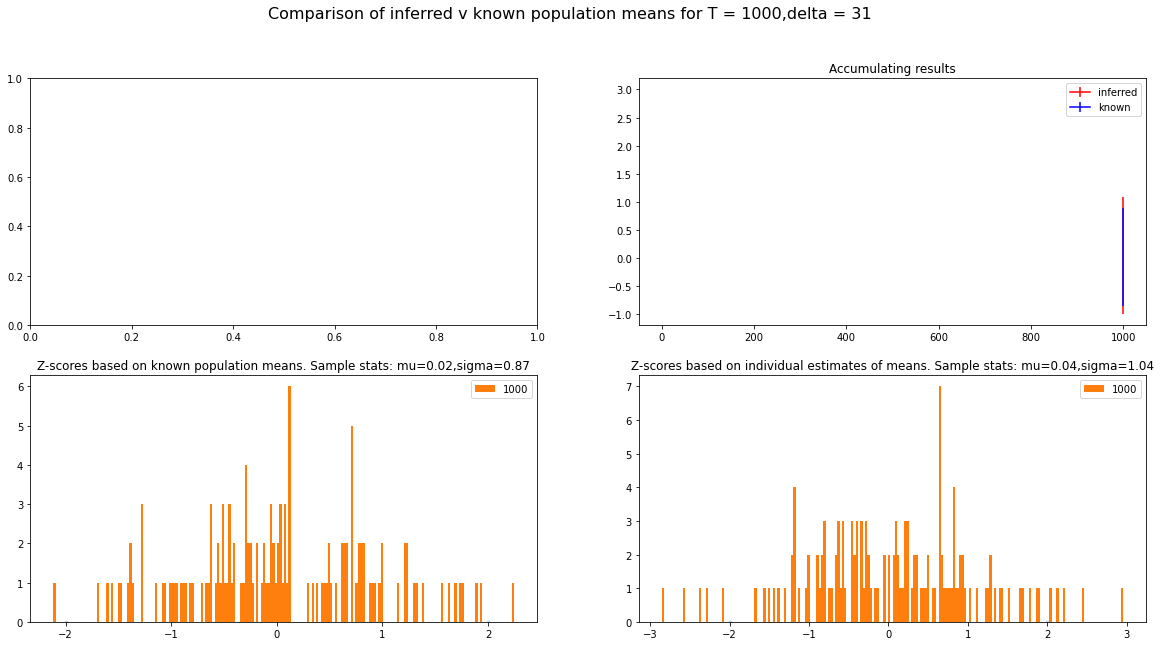

,T,Z score std dev (known means),Z score mean (known means),Z score std dev (inferred means),Z score mean (inferred means)
0,1000,1.04,0.044,0.873,0.018


NameError: name 'copy_from_temp' is not defined

In [18]:
import pointwise_correlation as pc
import time_series_correlation as tc
import testing_and_analysis_func as analysis_func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
plt.rcParams['figure.figsize']=[20,10]

pc.SHORT_TIME_SERIES_Z_SCORES = []
pc.EMPTY_TIME_SERIES_COUNT = 0
# parameter dictionary 
params_dict = {
#                'T' : 1000                        # Length of each time series
                'n' : 5000,                      # How many time series in each population
               'Use external intialisation' : True,
#               'Use population means' : True, # Refers to whether correlation calculation is based on pre-determined or measured means

                'Use fixed means for setup' : True, # Refers to whether non event-based poisson population(s) taken from given means or chai-squared dist
                'p1' : 0.1,
                'p2' : 0.5,            # mean occurences from which populations will be drawn if not based on an event time series 
    
#               'Test_mode' : False,
#                'dense' : True,  # only needed for time_series_correlation (obsolete class)
                'sparse': False # must be false - only dense time series can be analysed
                    } 


lengths=[1000]  # Which lengths of time series to run the algorithm for.  Only results from the final entry will be stored in TEMP directory

copy_results_out_of_temp_dir=True
# if combining multiple populations, these are the parameters for initialising.
multiple_population_params={'clusters':3,'pop_sizes':[5,7,10],
                            'mean lag range' : [2,int(np.sqrt(lengths[-1])/2)],
                            'event probability range':[100/lengths[-1],0.02],
                            'noise scaling' : 5}  
multiple_population_params['Time series length']=lengths[-1]
multiple_population_params['use fixed means']=params_dict['Use fixed means for setup']
# if method for re-clustering=None then  community detection analysis will not be performed.  Other options are 'greedy_Louvain'
multiple_population_params['method for re-clustering']='greedy Louvain'



# decide how to interpret the event probability range and mean lag range
# 'no interpretation' means the lists are passed as they are and their lengths must match the number of clusters
# 'given values only' means only the values given can be selected and these will be chosen randomly
# 'min max' means the values passed are the lower and higher limits and a uniform selection is made

#multiple_population_params['Method to interpret prob ranges']='no interpretation' # this passes the lists directly
multiple_population_params['Method to interpret prob ranges']=np.random.choice(['given values only','min max'])

pd.DataFrame.from_dict(multiple_population_params,orient='index').to_csv("{0}\meta_params.csv".format(pc.TEMP_DIR))



td_to_store,df=compare_inferred_and_known_means(version=pc,xs=lengths,params=params_dict,
                                    multiple_populations=True,multiple_pop_params=multiple_population_params,
                                    poisson_process=True,disjoint=False,verbose=True)
plt.show()
display(df)




if copy_results_out_of_temp_dir:
    analysis_func.copy_from_temp(dest_root_dir="{0}/Multiple_population_correlations".format(pc.RESULTS_DIR))


short_ts_data = np.array(pc.SHORT_TIME_SERIES_Z_SCORES)
print("Total of {0} empty time series found".format(pc.EMPTY_TIME_SERIES_COUNT))
print("Total of {0} time series calculations ignored (due to fewer than 4 events in one or both)".format(len(short_ts_data)))

if len(short_ts_data):
    df = pd.DataFrame(list(np.transpose([[min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],list(short_ts_data[:,2])])),
                      columns = ['Length of short time series','Z score'])
    print("Z_scores for comparisons involving very short series averaged : {0}".format(np.mean(short_ts_data[:,2])))
    #plt.plot([min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],short_ts_data[:,2], 'x')
    #plt.show()

#print("Mean and sigma for the z scores for empty time series are {0} and {1}".format(np.mean(z_scores), np.std(z_scores)))
#plt.hist(z_scores)
#print(td_to_store)

### Louvain method

Greedy algorithm used to identify clusters in networkx graph.  Edge probabilities are the z_scores from correlation measures.  F-score calculated on edges in clusters that correspond to objects in the same original populations.

Uncomment and run code below to use imported Louvain method above once results are stored in td_to_store

In [17]:
import Louvain
#Louvain.analyse_raw_results_for_scoring(td_to_store,repeats=1,reclustering='greedy Louvain',test_random_graph=False,pass_weights=True,verbose=True)

     p-value  Z-score name1 name2            id1            id2
3      0.964    1.796   Flo   Flo  2308879708680  2308879708512
6      0.660    0.411   Flo   Flo  2308879708680  2308879708960
8      0.831    0.958   Flo   Flo  2308879708680  2308879708792
10     0.808    0.870   Flo   Flo  2308879708680  2308879708624
12     0.910    1.343   Flo   Flo  2308879708680  2308879708848
..       ...      ...   ...   ...            ...            ...
281    0.534    0.086   Flo   Flo  2308879708736  2308879708568
284    0.246   -0.688   Flo   Flo  2308879708736  2308879708904
292    0.448   -0.131   Flo   Flo  2308879709016  2308879708568
295    0.207   -0.816   Flo   Flo  2308879709016  2308879708904
347    0.249   -0.678   Flo   Flo  2308879708568  2308879708904

[45 rows x 6 columns]
     p-value  Z-score name1 name2            id1            id2
30     0.469   -0.077  Owen  Owen  2308879601000  2308879600776
32     0.401   -0.251  Owen  Owen  2308879601000  2308879600888
42     0.604    0

Algorithm below initialises dense time series for correlation testing with various different possible options for initialisation (within tweet data class/externally using nultiple population processes).  If 'use fixed means for setup' is True then the two populations created have expected proportions of entries given by the 'means' dictionary list.  Otherwise each time series within both populations has an expected proportion of entries given by a random selection from a truncated chai-squared distribution.  If poisson_process is true then a poisson process is used to initialise.
The two populations of time series are returned in an array; the known probability from which each individual time series was drawn are stored are also returned as an array 

In [3]:
import time
import numpy as np
import poisson_processes as pp
import pointwise_correlation as pc

def initialise_time_series_matrices(length,number,use_fixed_means_for_setup=True,means=[0.01,0.2],\
                                    poisson_process=False,multiple_populations=False,multiple_pop_params={},verbose=True):
    T=length
    chi_scaling = np.log(10)/np.log(T)
    n=number
    #means_range = max(np.abs(means[0]-means[1]),0.1)
    #means_mean =(means[0]+means[1])/2
    if verbose:
        print("Now initialising externally")
    if use_fixed_means_for_setup:
        print("Initialising with fixed means")
        known_probs_array = [[p for i in range(n)] for p in means]
    else:
        print("Initialising with chi square dist")
        ps=[[chi_scaling*np.random.chisquare(6)/30 for i in range(n)] for j in range(2)]
        known_probs_array=[[p if (p and p<1) else np.random.uniform(min(means),max(means)) for p in vector] for vector in ps]
        
    
    if poisson_process:
        if multiple_populations:
            return initialise_multiple_populations(length,params=multiple_pop_params)
        
        else:
            Y1_betas = [1/p for p in known_probs_array[0]]
            Y2_betas = [1/p for p in known_probs_array[1]]
            if verbose:
                print("Initialising using poisson process")
        #lambdas = {'Y1': {'lambda':Y1_lambdas,'baseline':False},
        #        'Y2': {'lambda':Y2_lambdas,'baseline':False}
        #          }
            pp1 = pp.poisson_process(number = n, length = T, betas = Y1_betas)
            pp2 = pp.poisson_process(number=n,length=T,betas=Y2_betas)
            ts_matrices=[pp1.time_series_objects,pp2.time_series_objects]

                   
        return n,ts_matrices
            
    else:
        tweet_matrices=[[np.random.choice(range(T),size=int(np.random.normal(T*p,np.sqrt(T*p*(1-p)))),replace=False)\
                              for p in vector] for vector in known_probs_array]
        ts_matrices=[[pc.time_series(t_series,known_probs_array[i][j],T)\
                         for j,t_series in enumerate(tweet_matrix)] for i,tweet_matrix in enumerate(tweet_matrices)]

    return n,ts_matrices

In [3]:
#print(initialise_time_series_matrices(1000,20,poisson_process =True))

Algorithm tests the two sigma calculations (designated by inferred/known means).   A random set(s) of time series is created (by the tweet_data class method) and correlation z-scores calculated for all pairs of time series.  If disjoint=True, two populations are created and compared pairwise.  If disjoint=False, all pairs within a single population are compared.  Delta is fixed at sqrt(length of time series) but multiple lengths can be passed if required and the test will be carried out for each, with results plotted using both sigma calculations.  Overall results are plotted cumulatively with the final set of graphs contatining all data throughout.

Population means can be fixed in advance (if 'Use fixed means for setup' matches true in the parameter dictionary), or taken from a truncated chai squared distribution if not. 'Use population means is true initially so the later version of sigma is used in this first pass for each length of time series passed.  'Use population means' is then set to false allowing a run on the same data but using each individual time series to estimate the mean in the population from which it was taken.

In [2]:
import time
import Louvain

def compare_inferred_and_known_means(version,xs=[100,200],params={},poisson_process=False,disjoint=True,
                                     multiple_populations=False,multiple_pop_params={},verbose=False,axes=[]):
    """
    *Compares z_scores when means are inferred/known
    *Plot of sigma values for each against length of time series (given by parameter xs) is also shown
    *Number of time series given by parameter number (either in one or both populations)
    *If parameter disjoint is True, two separate populations are tested against each other pairwise
    *If disjoint is False, only one population is tested but all possible pairings are formed
    *If probs are None, individual probabilities are taken from a chai squared distribution
    """
    params_dict = params
    p1 = params_dict['p1']
    p2 = params_dict['p2']
    use_external_initialisation = params_dict['Use external intialisation']
    number=params_dict['n']
    ts=[]
    ys = [] # sigma values for z scores based on inferred means
    zs =[] # mean values for z scores based on inferred means
    y1s=[] # sigma values for z scores based on known population means
    z1s=[] #sigma values for z scores based on known population means
    start_time = time.time()
    
    # start run - for each length of time series (in array xs) correlations are measured for both sigma values
    for T in xs:
        # use maximum delta value
        delta = int(np.sqrt(T)) 
        ts.append(T)        
        print("T is {0}".format(T))

        # set up axes to display results
        f,axes = plt.subplots(2,2)
        f.suptitle("Comparison of inferred v known population means for T = {0},delta = {1}".format(T,delta),fontsize=16)
        #for ax in axes[0]:
        #    ax.plot([0,1],[0,0],'.',alpha=0.2)
        for ax in axes[1]:
            ax.plot([-2,2],[0,0],'.',alpha=0.2)
            
        # initialise time series if not initialising within tweet data class
        if use_external_initialisation:
            number,ts_matrices = initialise_time_series_matrices(T,number,use_fixed_means_for_setup=params['Use fixed means for setup'],\
                                                          means=[p1,p2],poisson_process=poisson_process,
                                                        multiple_populations=multiple_populations,multiple_pop_params=multiple_pop_params,verbose=verbose)
            # create time series objects for each time series
            #ts_matrices=[[pc.time_series(tweet_matrices[i][j],known_probs_array[i][j],T) for j in range(number)] 
            #                 for i in range(len(tweet_matrices))]
 
        else:
            ts_matrices = [] # will be initialised within the class
        
        # running just one matrix against itself
        #ts_matrices=[ts_matrices[0],ts_matrices[0]]
        
        # set parameters and instantiate classes
        params_dict['T'] = T
        params_dict['n'] = number # in case multiple populations have been combined
        if version == pc:
            td = version.tweet_data(ts_matrices,params_dict,delta = delta,
                        disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][1],axes[1][1]])
        #else:
        #    td = version.tweet_data(tweet_matrices=ts_matrices,population_ps = [p1,p2,params_dict],delta = delta,
        #                disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
 
        
        print("Running with inferred means.  Time elapsed: {0}".format(time.time()-start_time))        
        td.params['Use population means']=False
        #td.population_ps=[params[0],params[1],params_dict]

        td.display_Z_vals()
        ys.append(np.std(td.results))
        zs.append(np.mean(td.results))
        Louvain.analyse_raw_results_for_scoring(td,reclustering=multiple_population_params.get('method for re-clustering'))
        
        
        td.params['Use population means']=True
        #td.population_ps=[params[0],params[1],params_dict]
        td.axes=[axes[0][0],axes[1][0]]
        print("Running with population means. Time elapsed: {0}".format(time.time()-start_time))
        
        td.display_Z_vals()
        y1s.append(np.std(td.results))
        z1s.append(np.mean(td.results))
        Louvain.analyse_raw_results_for_scoring(td,reclustering=multiple_population_params.get('method for re-clustering'))
        
        #pd.DataFrame(np.transpose([ts,zs,ys,z1s,y1s])).to_csv("{0}/Accumulating results.csv".format(TEMP_DIR))
    
        axes[0][1].errorbar(ts,zs,ys,color='r',label='inferred')
        axes[0][1].errorbar(ts,z1s,y1s,color='b',label='known')
        axes[0][1].set_title("Accumulating results")
        axes[0][1].legend()
        axes[1][0].legend()
        axes[1][1].legend()
        
        plt.show()
    df=pd.concat([pd.DataFrame(xs,columns=['T']),
                   pd.DataFrame(ys,columns=['Z score std dev (known means)']),
                   pd.DataFrame(zs,columns=['Z score mean (known means)']),
                   pd.DataFrame(y1s,columns=['Z score std dev (inferred means)']),
                   pd.DataFrame(z1s,columns=['Z score mean (inferred means)'])],axis=1)
    #df.to_csv("{0}/Sigma_comparison{1}.csv".format(TEMP_DIR,str(xs)[:10]),mode='a')
    return td,df

The cell below initialises multiple populations of poisson processes, with each population based on a different event time series.  These event time series are chosen randomly with incidence governed by the event_beta parameters.  The nose_betas determine the incidence of random noise added to each population and the amount of lag for individuals in a population is determined by the mean_lags parameters.    

In [1]:
import poisson_processes as pp
#default_params={'clusters':2,'event probability range':[0.1,0.2],'noise scaling' : 1,'pop_sizes':[5,10]}
def initialise_multiple_populations(length,params):

    #if not 'clusters' in params.keys():
    #    params=default_params
    #print(params.keys())
    clusters=params['clusters']
    mean_lag_range=params['mean lag range']
    event_probability_range=params['event probability range']
    noise_scaling=params['noise scaling']
    max_noise_prob=0.5
    use_fixed_means=params.get('use fixed means')
    method_for_p_range = params['Method to interpret prob ranges']
    
    pop_sizes=np.random.choice(params['pop_sizes'],size=clusters)  
    if clusters < 7:
        pop_names=np.random.choice(['Jill','Rosa','Flo','Luke','Owen','Tom','Elena'],size=clusters,replace=False)
    else:
        pop_names=np.random.choice(list(range(clusters)),size=clusters,replace=False)  
        pop_names=[str(p) for p in pop_names]

        
    # initialise event/noise probability and lag values (first option below is just for testing)
    if method_for_p_range == 'no interpretation':
        event_probs=event_probability_range
        noise_probs=[e*noise_scaling for e in event_probability_range]
        mean_lags=mean_lag_range
        
    elif method_for_p_range == 'min max':
        # set up allowable ranges for events,noise and lag
        ep_lower=event_probability_range[0]
        ep_higher=event_probability_range[-1]
        noise_lower=min(ep_lower*noise_scaling,max_noise_prob)
        noise_higher=min(ep_higher*noise_scaling,max_noise_prob)
        lag_lower=mean_lag_range[0]
        lag_upper=mean_lag_range[-1]
        
        event_probs=np.random.uniform(ep_lower,ep_higher,size=clusters)
        noise_probs=np.random.uniform(noise_lower,noise_higher,size=clusters)
        mean_lags=np.random.uniform(lag_lower,lag_upper,size=clusters)
        
    elif method_for_p_range == 'given values only':
        event_probs=np.random.choice(event_probability_range,size=clusters)
        noise_probs=np.random.choice([e*noise_scaling for e in event_probability_range],size=clusters)
        mean_lags=np.random.choice(mean_lag_range,size=clusters)
        
        






    

   
    mpp=pp.initialise_multiple_populations(length=length,sizes=pop_sizes,keys=pop_names,
                                            event_probs=event_probs,mean_lags=mean_lags,noise_probs=noise_probs,
                                           use_fixed_means=use_fixed_means,verbose=False)
        
    ts_obj1=mpp.randomly_mix_populations(pop_names)
    number=len(ts_obj1)        
    ts_obj2=[]
    return number,[ts_obj1,ts_obj2]